In [1]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.optim import AdamW
from dataset import *
from tqdm import tqdm

In [3]:
# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
train_path = "../data/gsm8k_aug_train.jsonl"
test_path = "../data/gsm8k_aug_test.jsonl"

save_dir = "teacher_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# hyperpara
batch_size = 32
grad_accum_steps = 4
lr = 5e-4
warmup_ratio = 0.1
max_len = 512
max_epochs = 10

model_name = "gpt2"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

train_dataset = CoTJSONLDataset(train_path, max_len=max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_teacher, num_workers=2)
test_dataset = CoTJSONLDataset(test_path, max_len=max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_teacher, num_workers=2)

NVIDIA GeForce RTX 3090


In [6]:
optim = AdamW(model.parameters(), lr=lr, weight_decay=0.01)

# total_steps = len(train_loader) // grad_accum_steps * max_epochs
# sched = get_linear_schedule_with_warmup(
#     optim,
#     num_warmup_steps=int(total_steps * warmup_ratio),
#     num_training_steps=total_steps
# )


In [7]:
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

total_steps = len(train_loader) // grad_accum_steps * max_epochs
warmup_steps = int(total_steps * warmup_ratio)
lr_min_factor = 0.1   # min_lr = 0.1 * base_lr

def lr_lambda(current_step: int):
    if current_step < warmup_steps:
        # 线性warmup: 0 -> 1
        return float(current_step) / float(max(1, warmup_steps))
    # 余弦衰减部分
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine_decay = 0.5 * (1.0 + np.cos(np.pi * progress))
    return lr_min_factor + (1 - lr_min_factor) * cosine_decay

sched = LambdaLR(optim, lr_lambda)


In [8]:
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

def compute_losses(outputs, labels, r_mask, a_mask):
    # logits: [B, L, V], labels: [B, L]
    logits = outputs.logits[:, :-1, :]         # shift for causal LM
    labels = labels[:, 1:]
    r_mask = r_mask[:, 1:]
    a_mask = a_mask[:, 1:]

    vocab_size = logits.size(-1)
    loss_all = loss_fn(logits.reshape(-1, vocab_size), labels.reshape(-1))  # [B*L]
    loss_all = loss_all.view(labels.size(0), labels.size(1))

    # reasoning loss
    r_loss = (loss_all * r_mask).sum() / (r_mask.sum() + 1e-8)

    # answer loss
    a_loss = (loss_all * a_mask).sum() / (a_mask.sum() + 1e-8)

    # 总loss（可加权，这里直接相加）
    total_loss = (loss_all * (r_mask + a_mask)).sum() / ((r_mask + a_mask).sum() + 1e-8)

    return total_loss, r_loss, a_loss


In [9]:
def evaluate(model, data_loader):
    model.eval()
    total_losses, r_losses, a_losses = [], [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            r_mask = batch["r_mask"].to(device)
            a_mask = batch["a_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attn, labels=None, return_dict=True)
            total_loss, r_loss, a_loss = compute_losses(outputs, labels, r_mask, a_mask)
            total_losses.append(total_loss.item())
            r_losses.append(r_loss.item())
            a_losses.append(a_loss.item())

    model.train()
    return np.mean(total_losses), np.mean(r_losses), np.mean(a_losses)

In [10]:
raw_losses = []       # 每个 batch 的训练 loss
raw_r_losses = []
raw_a_losses = []

test_losses = []      # 每个 epoch 的测试 loss
test_r_losses = []
test_a_losses = []

train_losses = []     # 每个 epoch 的训练 loss
train_r_losses = []
train_a_losses = []

best_test_loss = float("inf")

for epoch in range(max_epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    optim.zero_grad()

    for step, batch in enumerate(pbar):
        input_ids = batch["input_ids"].to(device)
        attn = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        r_mask = batch["r_mask"].to(device)
        a_mask = batch["a_mask"].to(device) 

        outputs = model(input_ids=input_ids, attention_mask=attn, labels=None, return_dict=True)
        total_loss, r_loss, a_loss = compute_losses(outputs, labels, r_mask, a_mask)

        raw_losses.append(total_loss.item())
        raw_r_losses.append(r_loss.item())
        raw_a_losses.append(a_loss.item())
        loss = total_loss / grad_accum_steps
        loss.backward()

        if (step + 1) % grad_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()
            sched.step()
            optim.zero_grad()

        pbar.set_postfix({"loss": float(loss.item() * grad_accum_steps)})

    # 平均训练 loss
    avg_train_loss = np.mean(raw_losses[-len(train_loader):])
    avg_train_r_loss = np.mean(raw_r_losses[-len(train_loader):])
    avg_train_a_loss = np.mean(raw_a_losses[-len(train_loader):])

    train_losses.append(avg_train_loss)
    train_r_losses.append(avg_train_r_loss)
    train_a_losses.append(avg_train_a_loss)

    # ------------------------------
    # 在每个 epoch 结束时评估 test loss
    # ------------------------------
    avg_test_loss, avg_test_r_loss, avg_test_a_loss = evaluate(model, test_loader)
    test_losses.append(avg_test_loss)
    test_r_losses.append(avg_test_r_loss)
    test_a_losses.append(avg_test_a_loss)

    print(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")
    print(f"Epoch {epoch} - Train reasoning Loss: {avg_train_r_loss:.4f} | Test reasoning Loss: {avg_test_r_loss:.4f}")
    print(f"Epoch {epoch} - Train answer Loss: {avg_train_a_loss:.4f} | Test answer Loss: {avg_test_a_loss:.4f}")

    # ------------------------------
    # 保存模型 checkpoint
    # ------------------------------
    ckpt_path = os.path.join(save_dir, f"0828_teacher_epoch_{epoch}.pt")
    torch.save(model.state_dict(), ckpt_path)

    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_path = os.path.join(save_dir, "0828_teacher_best_model.pt")
        torch.save(model.state_dict(), best_path)
        print(f"✅ Best model updated at epoch {epoch}, saved to {best_path}")

print("Training finished.")


Epoch 0: 100%|██████████| 12051/12051 [46:59<00:00,  4.27it/s, loss=0.346]


Epoch 0 - Train Loss: 0.5693 | Test Loss: 0.4878
Epoch 0 - Train reasoning Loss: 0.6193 | Test reasoning Loss: 0.4877
Epoch 0 - Train answer Loss: 0.2423 | Test answer Loss: 0.4854
✅ Best model updated at epoch 0, saved to teacher_checkpoints/0828_teacher_best_model.pt


Epoch 1: 100%|██████████| 12051/12051 [46:59<00:00,  4.27it/s, loss=0.147]


Epoch 1 - Train Loss: 0.2648 | Test Loss: 0.4146
Epoch 1 - Train reasoning Loss: 0.2935 | Test reasoning Loss: 0.4128
Epoch 1 - Train answer Loss: 0.0771 | Test answer Loss: 0.4273
✅ Best model updated at epoch 1, saved to teacher_checkpoints/0828_teacher_best_model.pt


Epoch 2: 100%|██████████| 12051/12051 [47:05<00:00,  4.26it/s, loss=0.207] 


Epoch 2 - Train Loss: 0.2046 | Test Loss: 0.4007
Epoch 2 - Train reasoning Loss: 0.2266 | Test reasoning Loss: 0.3930
Epoch 2 - Train answer Loss: 0.0612 | Test answer Loss: 0.4619
✅ Best model updated at epoch 2, saved to teacher_checkpoints/0828_teacher_best_model.pt


Epoch 3: 100%|██████████| 12051/12051 [47:09<00:00,  4.26it/s, loss=0.222] 


Epoch 3 - Train Loss: 0.1676 | Test Loss: 0.3941
Epoch 3 - Train reasoning Loss: 0.1855 | Test reasoning Loss: 0.3898
Epoch 3 - Train answer Loss: 0.0511 | Test answer Loss: 0.4213
✅ Best model updated at epoch 3, saved to teacher_checkpoints/0828_teacher_best_model.pt


Epoch 4: 100%|██████████| 12051/12051 [47:03<00:00,  4.27it/s, loss=0.132] 


Epoch 4 - Train Loss: 0.1387 | Test Loss: 0.3911
Epoch 4 - Train reasoning Loss: 0.1533 | Test reasoning Loss: 0.3828
Epoch 4 - Train answer Loss: 0.0429 | Test answer Loss: 0.4541
✅ Best model updated at epoch 4, saved to teacher_checkpoints/0828_teacher_best_model.pt


Epoch 5: 100%|██████████| 12051/12051 [47:05<00:00,  4.26it/s, loss=0.133] 


Epoch 5 - Train Loss: 0.1129 | Test Loss: 0.4225
Epoch 5 - Train reasoning Loss: 0.1247 | Test reasoning Loss: 0.4193
Epoch 5 - Train answer Loss: 0.0360 | Test answer Loss: 0.4433


Epoch 6: 100%|██████████| 12051/12051 [47:03<00:00,  4.27it/s, loss=0.0883]


Epoch 6 - Train Loss: 0.0896 | Test Loss: 0.4508
Epoch 6 - Train reasoning Loss: 0.0988 | Test reasoning Loss: 0.4445
Epoch 6 - Train answer Loss: 0.0292 | Test answer Loss: 0.4945


Epoch 7: 100%|██████████| 12051/12051 [47:06<00:00,  4.26it/s, loss=0.104] 


Epoch 7 - Train Loss: 0.0698 | Test Loss: 0.5082
Epoch 7 - Train reasoning Loss: 0.0768 | Test reasoning Loss: 0.4991
Epoch 7 - Train answer Loss: 0.0238 | Test answer Loss: 0.5776


Epoch 8: 100%|██████████| 12051/12051 [47:00<00:00,  4.27it/s, loss=0.0466]


Epoch 8 - Train Loss: 0.0547 | Test Loss: 0.5599
Epoch 8 - Train reasoning Loss: 0.0601 | Test reasoning Loss: 0.5561
Epoch 8 - Train answer Loss: 0.0193 | Test answer Loss: 0.5793


Epoch 9: 100%|██████████| 12051/12051 [47:04<00:00,  4.27it/s, loss=0.0351] 


Epoch 9 - Train Loss: 0.0451 | Test Loss: 0.6199
Epoch 9 - Train reasoning Loss: 0.0495 | Test reasoning Loss: 0.6163
Epoch 9 - Train answer Loss: 0.0164 | Test answer Loss: 0.6494
Training finished.


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_losses(raw_losses, raw_r_losses, raw_a_losses,
                train_losses, train_r_losses, train_a_losses,
                test_losses, test_r_losses, test_a_losses,
                train_loader, window_size=50):

    def moving_average(data, window_size):
        if len(data) >= window_size:
            return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
        else:
            return data

    # 计算滑动平均
    ma_total = moving_average(raw_losses, window_size)
    ma_r = moving_average(raw_r_losses, window_size)
    ma_a = moving_average(raw_a_losses, window_size)

    x_ma = np.arange(window_size-1, window_size-1 + len(ma_total))

    plt.figure(figsize=(14,10))

    # ---------- 1. 总 loss ----------
    plt.subplot(3,1,1)
    plt.plot(raw_losses, label="Batch Total Loss", alpha=0.4)
    plt.plot(x_ma, ma_total, color='red', label=f"Total Moving Avg ({window_size})", linewidth=2)
    plt.plot(np.arange(1, len(train_losses)+1)*len(train_loader), train_losses, marker="o", color="blue", label="Epoch Train Total Loss")
    plt.plot(np.arange(1, len(test_losses)+1)*len(train_loader), test_losses, marker="s", color="green", label="Epoch Test Total Loss")
    plt.ylabel("Total Loss")
    plt.title("Total Loss (Training & Test)")
    plt.legend()
    plt.grid(True)

    # ---------- 2. reasoning loss ----------
    plt.subplot(3,1,2)
    plt.plot(raw_r_losses, label="Batch Reasoning Loss", alpha=0.4)
    plt.plot(x_ma, ma_r, color='red', label=f"Reasoning Moving Avg ({window_size})", linewidth=2)
    plt.plot(np.arange(1, len(train_r_losses)+1)*len(train_loader), train_r_losses, marker="o", color="blue", label="Epoch Train Reasoning Loss")
    plt.plot(np.arange(1, len(test_r_losses)+1)*len(train_loader), test_r_losses, marker="s", color="green", label="Epoch Test Reasoning Loss")
    plt.ylabel("Reasoning Loss")
    plt.title("Reasoning Loss (Training & Test)")
    plt.legend()
    plt.grid(True)

    # ---------- 3. answer loss ----------
    plt.subplot(3,1,3)
    plt.plot(raw_a_losses, label="Batch Answer Loss", alpha=0.4)
    plt.plot(x_ma, ma_a, color='red', label=f"Answer Moving Avg ({window_size})", linewidth=2)
    plt.plot(np.arange(1, len(train_a_losses)+1)*len(train_loader), train_a_losses, marker="o", color="blue", label="Epoch Train Answer Loss")
    plt.plot(np.arange(1, len(test_a_losses)+1)*len(train_loader), test_a_losses, marker="s", color="green", label="Epoch Test Answer Loss")
    plt.xlabel("Batch")
    plt.ylabel("Answer Loss")
    plt.title("Answer Loss (Training & Test)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


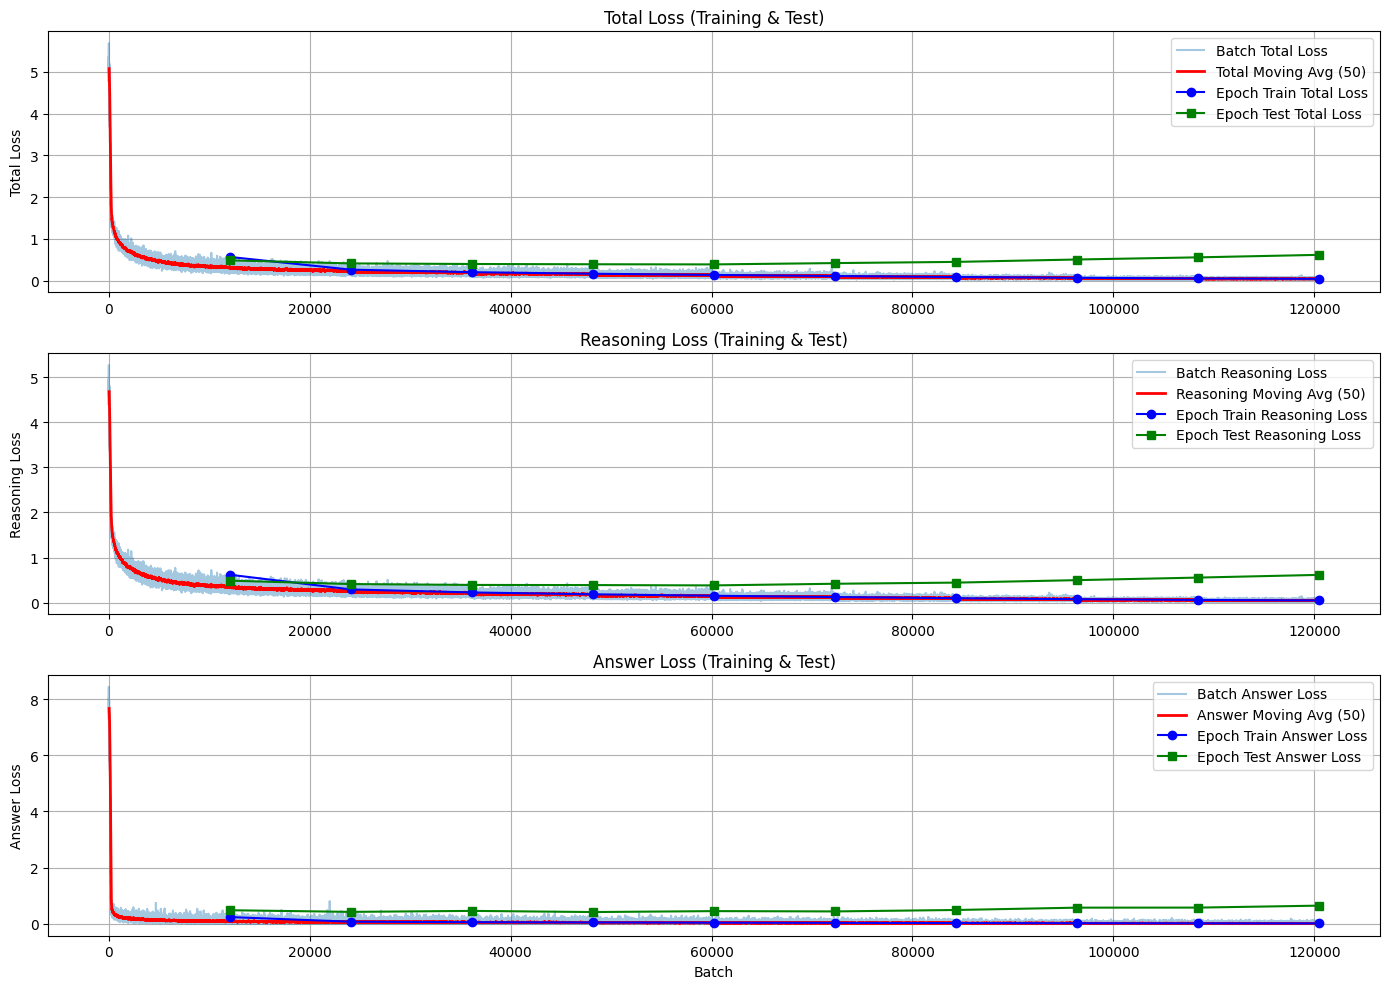

In [12]:
plot_losses(raw_losses, raw_r_losses, raw_a_losses,
            train_losses, train_r_losses, train_a_losses,
            test_losses, test_r_losses, test_a_losses,
            train_loader)
